In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib as mpl


plt.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.linewidth'] = 2 
set_tex = lambda tex=True: plt.rcParams.update({"text.usetex": tex})
mpl.rc('xtick', labelsize=12) 
mpl.rc('ytick', labelsize=12) 


In [2]:
np.random.seed(1)
rng = lambda n = 1: np.random.randn(n)

In [3]:
types = {'x': ['shifted_spot', 'min_max', 'mean'],
         'vol': ['I', 'II', 'III', 'IV']}

In [429]:
types

{'x': ['shifted_spot', 'min_max', 'mean'], 'vol': ['I', 'II', 'III', 'IV']}

In [430]:
smooth = False

In [433]:
func = (lambda s, x: 1 * (s / x <= 1.)) if smooth else (lambda s, x: 1 * (.5 * (1. + np.tanh(s / x)) <= 1.))

In [436]:
scale = 2.

In [443]:
heaviside = lambda x: 1 * (x > 0.)
hyperb = lambda x: .5 * (1. + np.tanh(x / scale))

In [445]:
hyperb(0)

0.5

In [493]:
def vol_pdv(s, x, vol_min, vol_max, type = ('shifted_spot', 'I'), pars = None, smooth = False):
    func_ = heaviside if not smooth else hyperb
    
    if (type[1] in ['III', 'IV']) and (pars is not None):
        kappa, sig_0, delta = pars.values()
        const = kappa * sig_0 * np.sqrt(delta)
    
    match type:
        case ('shifted_spot', 'I'):
            return vol_max * (func_(1. - s / x) + (s / x == 1.)) + vol_min * func_(s / x - 1.)
        case ('mean', 'I'):
            return vol_max * (func_(1. - s / x) + (s / x == 1.)) + vol_min * func_(s / x - 1.)
        case ('min_max', 'II'):
            return vol_max * (func_(.5 - (s - x[0]) / (x[1] - x[0])) + (s - x[0]) / (x[1] - x[0]) == .5) + vol_min * func_((s - x[0]) / (x[1] - x[0]) - .5)
        case ('shifted_spot', 'III'):
           return vol_max * func_(np.abs((s - x) / x) - const)  + vol_min * (func_(const - np.abs((s - x) / x)) + np.abs((s - x) / x) == const)
        case ('mean', 'III'):
            return vol_max * func_(np.abs((s - x) / x) - const)  + vol_min * (func_(const - np.abs((s - x) / x)) + np.abs((s - x) / x) == const)
        case ('min_max', 'IV'):
            return vol_max * func_((x[1] - x[0]) / x[0]  - const) + vol_min * (func_(const  - (x[1] - x[0]) / x[0]) + (x[1] - x[0]) / x[0] == const)

In [6]:
vol_min, vol_max = .1, .4
dt = 5. / 252.
delta = 4 * dt

In [239]:
from scipy.integrate import simpson, quad

In [275]:
def integ(x, a, b):
    out = np.zeros(x.shape[0])
    for n in range(out.shape[0]):
        out[n] = quad(lambda t:  x[n, int(t / dt)], a, b)[0]
    return out

In [294]:
def generate_factor(t, delta, s, type_x = 'shifted_spot'):
    
    delta_ = np.minimum(t, delta)
    match type_x:
        case 'shifted_spot':
            return s[:, int((t - delta_) / dt)]
        
        case 'min_max':
            return s[:, int((t - delta_) / dt): int(t / dt) + 1].min(axis = 1), s[:, int((t - delta_) / dt): int(t / dt) + 1].max(axis = 1)
        case 'mean':
            
            #simpson(s[:, int((t - delta) / dt): int(t / dt) + 1], grid_t) / delta
            #delta_ = np.minimum(t, delta)
            local_traj = s[:, int((t - delta_) / dt): int(t / dt) + 1]
            grid_t = np.linspace(t - delta_, t, local_traj.shape[1])
            return simpson(local_traj, grid_t) / delta_ #integ(local_traj, t - delta_, t) / delta_

In [232]:
s = np.random.randn(5, 7)

In [233]:
local_traj = s[:, int((5 * dt - delta) / dt): int(5*dt / dt) + 1]

In [234]:
print(s)

[[ 0.11835804 -1.20150101  3.04522587  0.80768562 -1.85301646 -0.85431499
   1.11539174]
 [-1.66121425 -0.5203575  -0.10545742 -0.37765759 -0.25820249 -1.69986847
   0.75916457]
 [-1.19732808 -1.1301505   0.69817589  0.21871187  0.56542976 -0.04011762
  -0.36856291]
 [ 1.22937202 -1.02334159 -0.53981542 -0.37413817 -0.01259426 -0.04413121
  -0.52642109]
 [-1.26282926 -0.53693837  0.52418335  0.05401824 -0.91075099 -1.07165736
  -1.40898349]]


In [235]:
local_traj

array([[-1.20150101,  3.04522587,  0.80768562, -1.85301646, -0.85431499],
       [-0.5203575 , -0.10545742, -0.37765759, -0.25820249, -1.69986847],
       [-1.1301505 ,  0.69817589,  0.21871187,  0.56542976, -0.04011762],
       [-1.02334159, -0.53981542, -0.37413817, -0.01259426, -0.04413121],
       [-0.53693837,  0.52418335,  0.05401824, -0.91075099, -1.07165736]])

In [270]:
def integ(x, a, b):
    out = np.zeros(x.shape[0])
    for n in range(out.shape[0]):
        out[n] = quad(lambda t:  x[n, int(t / dt)], a, b)[0]
    return out

In [272]:
integ(local_traj, 5 * dt - delta, 5*dt) / delta

array([ 0.28639501, -0.61029649,  0.36054997, -0.24266976, -0.35105169])

In [274]:
generate_factor(5*dt, delta, s, 'mean')

array([ 0.36069941, -0.36918173,  0.36013152, -0.33544899, -0.25390248])

{'kappa': 1.0, 'sig_0': 0.2, 'delta': 0.07936507936507936}

In [512]:
def generate_paths(n_samples, delta, dt, s_0, time_bounds, 
                   type = ('shifted_spot', 'I'), pars = None, smooth = False):
    
    if type[1] in ['III', 'IV']:
        pars_ = {key: pars[key] for key in ['kappa', 'sig_0', 'delta']}
    else: pars_ = None
    
    vol_min, vol_max = pars['vol_min'], pars['vol_max']
    vol_ = lambda s, x: vol_pdv(s, x, vol_min, vol_max, type, 
                                pars = pars_, smooth = smooth)
    n_t_grid = int((time_bounds[1] - time_bounds[0]) / dt)
    s = np.zeros((n_samples, n_t_grid + 1))
    
    if type[0] == 'min_max':
        x_min, x_max = np.zeros((n_samples, n_t_grid)), np.zeros((n_samples, n_t_grid))
    else:
        x = np.zeros((n_samples, n_t_grid))
    
    s[:, 0] = s_0
    for n in range(1, n_t_grid + 1):
        z = rng(n_samples)
        if type[0] == 'min_max':
            x_min[:, n - 1], x_max[:, n - 1] = generate_factor(n * dt, delta, s, type[0])
            x_ = np.vstack((x_min[:, n-1], x_max[:, n - 1]))
        else:
            x[:, n - 1] = generate_factor(n * dt, delta, s, type[0])
            x_ = x[:, n - 1]

        s[:, n] = s[:, n - 1] * (1. + vol_(s[:, n - 1], x_) * np.sqrt(dt) * z)
    
    x = np.array([x_min, x_max]) if type[0] == 'min_max' else x
    return s, x, vol_, n_t_grid


In [316]:
n_samples = 1_000
s_0 = 100.
time_bounds = np.array([0., 1.])

In [505]:
pars = {'vol_min': vol_min, 'vol_max': vol_max,
        'kappa': 1., 'sig_0': .2, 'delta': delta}

In [456]:
s, x, vol_, n_t_grid = generate_paths(n_samples, delta, dt, s_0, time_bounds, pars = pars, smooth = True)

In [497]:
s.shape

(10000, 51)

In [225]:
t_grid = np.arange(0., 1., dt)

In [83]:
set_tex(True)

In [311]:
def plot_spot_vol(s, x, vol_, t_grid, idx, label = r'$S_{t - \Delta}$'):
    fig, axs = plt.subplots(1, 2, figsize = (15, 5))

    axs[0].plot(t_grid, s[idx, :], '.-', color = 'navy', label = r'$S_t$')
    axs[0].plot(t_grid[4:], x[idx, 3:], '.--', color = 'firebrick', label = label)

    axs[1].plot(t_grid[4:], vol_(s[idx, 4:], x[idx, 3:]), '.--', color = 'darkmagenta', label = r'$\sigma(S_t, X_t)$')
    for ax in axs:
        ax.legend(edgecolor = 'k')
    plt.tight_layout()

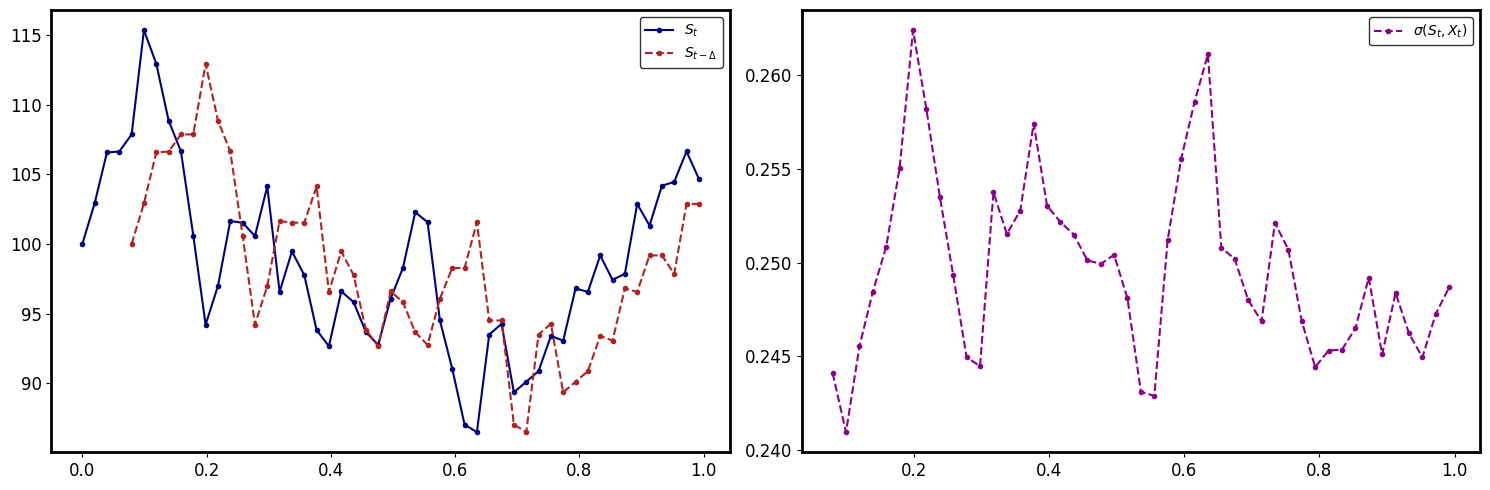

In [457]:
plot_spot_vol(s, x, vol_, t_grid, 0)
#plt.savefig('shifted_spot.pdf', format = 'pdf')

In [313]:
idx = 0

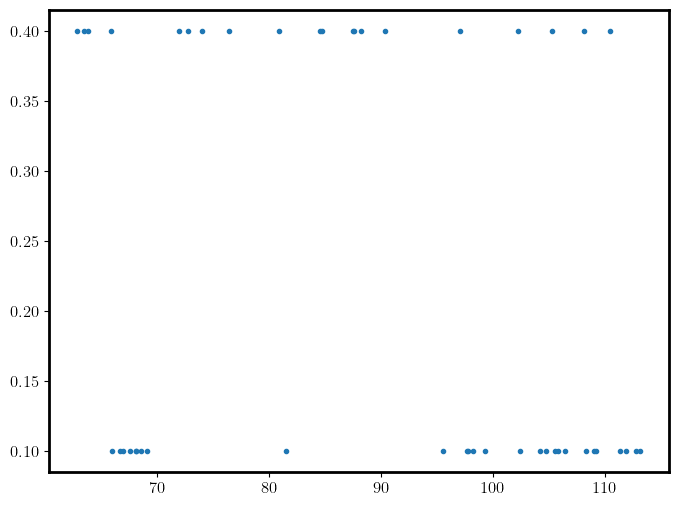

In [334]:
plt.plot(s[idx, 4:], vol_(s[idx, 4:], x[idx, 3:]), '.')

In [495]:
s, x, vol_, n_t_grid = generate_paths(n_samples, delta, dt, s_0, time_bounds, type = ('shifted_spot', 'III'), pars = pars, smooth = True)

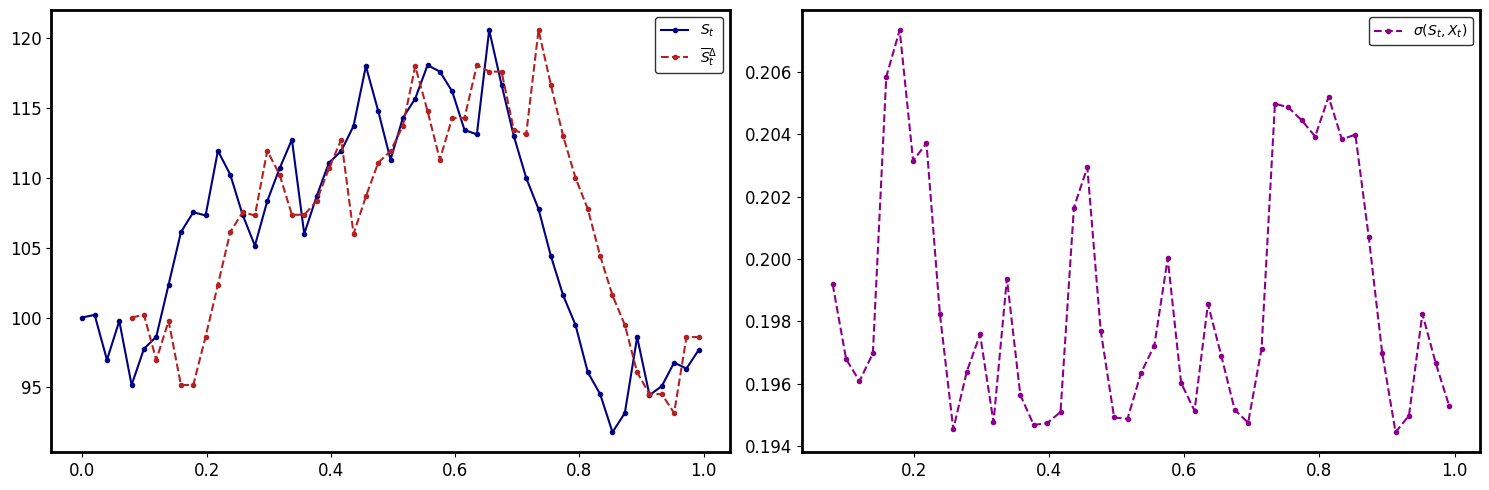

In [496]:
plot_spot_vol(s, x, vol_, t_grid, 0, r'$\overline{S}_t^\Delta$')

In [461]:
n_samples = 10_000

In [477]:
k = np.linspace(-1.5, 1.5, 15)
strikes = s_0 * np.exp(k)

In [482]:
s, x, vol_, n_t_grid = generate_paths(n_samples, delta, dt, s_0, time_bounds,type = ('mean', 'I'),  pars = pars, smooth = True)

In [464]:
# all inputs must be scalar
norm = stats.norm
def blackscholes_impv_scalar(K, T, S, value, r=0, q=0, callput='call', tol=1e-10, maxiter=1000):
    """Compute implied vol in Black-Scholes model
    
    Parameters
    ----------
    K: scalar
        The strike of the option.
    T: scalar
        The maturity of the option.
    S: scalar
        The spot price of the underlying security.
    value: scalar
        The value of the option
    callput: str
        Must be either 'call' or 'put'

    Returns
    -------
    vol: scalar
        The implied vol of the option.
    """
    if (K <= 0) or (T <= 0):
        return np.nan
    F = S*np.exp((r-q)*T)
    K = K/F
    value = value*np.exp(r*T)/F
    callput = callput.lower()
    if callput not in ['call', 'put']:
        raise ValueError('The value of "callput" must be either "call" or "put"')
    opttype = 1 if callput == 'call' else -1
    value -= max(opttype * (1 - K), 0)
    if value < 0:
        return np.nan
    if (value == 0):
        return 0
    j = 1
    p = np.log(K)
    if K >= 1:
        x0 = np.sqrt(2 * p)
        x1 = x0 - (0.5 - K * norm.cdf(-x0) - value) * np.sqrt(2*np.pi)
        while (abs(x0 - x1) > tol*np.sqrt(T)) and (j < maxiter):
            x0 = x1
            d1 = -p/x1+0.5*x1
            x1 = x1 - (norm.cdf(d1) - K*norm.cdf(d1-x1)-value)*np.sqrt(2*np.pi)*np.exp(0.5*d1**2)
            j += 1
        return x1 / np.sqrt(T)
    else:
        x0 = np.sqrt(-2 * p)
        x1 = x0 - (0.5*K-norm.cdf(-x0)-value)*np.sqrt(2*np.pi)/K
        while (abs(x0-x1) > tol*np.sqrt(T)) and (j < maxiter):
            x0 = x1
            d1 = -p/x1+0.5*x1
            x1 = x1-(K*norm.cdf(x1-d1)-norm.cdf(-d1)-value)*np.sqrt(2*np.pi)*np.exp(0.5*d1**2)
            j += 1
        return x1 /np.sqrt(T)

# vectorized version
blackscholes_impv = np.vectorize(blackscholes_impv_scalar, excluded={'callput', 'tol', 'maxiter'})

# Example
blackscholes_impv(K=95, T=0.25, S=100, value=7, callput='call')

array(0.20654803)

In [498]:
prices = np.maximum(np.subtract.outer(strikes, s[:, -1]), 0.).mean(axis = 1) + s_0 - strikes

In [499]:
vols = blackscholes_impv(strikes, 1., s_0, prices)

In [369]:
set_tex(False)

In [500]:
vols

array([       nan,        nan,        nan, 0.        , 0.19939764,
       0.20040138, 0.19915616, 0.19932142, 0.20444981, 0.2305866 ,
       0.29821844, 0.3755701 , 0.4505702 , 0.52267849, 0.59236293])

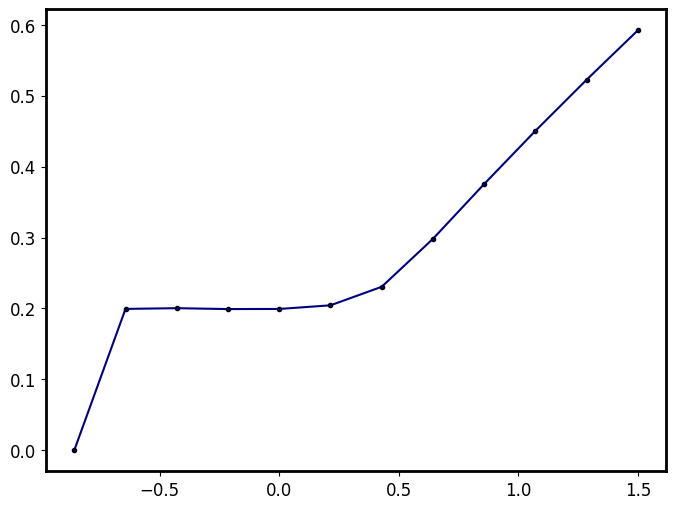

In [501]:
plt.plot(k, vols, '.-', color = 'navy', markeredgecolor = 'k')

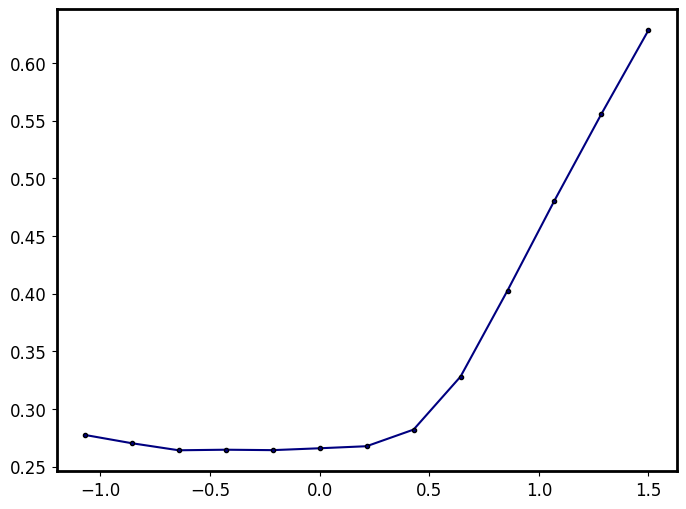

In [481]:
plt.plot(k, vols, '.-', color = 'navy', markeredgecolor = 'k')

In [520]:
def bs_call_price(t, spot, strikes, T, sig, r = 0., q = 0.):
    d_1 = np.log(spot * np.exp((r - q) * (T - t)) / strikes) / (sig * np.sqrt(T - t)) + .5 * sig * np.sqrt(T - t)
    d_2 = d_1 - sig * np.sqrt(T - t)
    return spot * np.exp(-q * (T - t)) * norm.cdf(d_1) - strikes * np.exp(-r * (t - t)) * norm.cdf(d_2)

In [521]:
bs_call_price(0., s_0, strikes, 1., .2)

array([7.76869840e+01, 7.23546953e+01, 6.57481146e+01, 5.75627406e+01,
       4.74237340e+01, 3.49484116e+01, 2.05882118e+01, 7.96556746e+00,
       1.61065284e+00, 1.41712966e-01, 4.82411413e-03, 5.92756892e-05,
       2.52315017e-07, 3.62802828e-10, 1.73395167e-13])

In [543]:
def obj(x, strikes, n_samples, sig_m):
    pars = {'vol_min': x[0], 'vol_max': x[1]}
    
    s, _, vol_, n_t_grid = generate_paths(n_samples, delta, dt, s_0, time_bounds, pars = pars, smooth = True)
    prices = np.maximum(np.subtract.outer(strikes, s[:, -1]), 0.).mean(axis = 1) + s_0 - strikes
    bs_prices = bs_call_price(0., s_0, strikes, 1., sig_m)
    return np.linalg.norm(bs_prices - prices) 
    #return np.linalg.norm(sig_m - blackscholes_impv(strikes, 1., s_0, prices))

In [548]:
vol_min, vol_max = np.linspace(1e-3, 1., 50), np.linspace(1e-3, 1., 50)
x = np.column_stack((vol_min, vol_max))

In [550]:
x

array([[0.001     , 0.001     ],
       [0.02138776, 0.02138776],
       [0.04177551, 0.04177551],
       [0.06216327, 0.06216327],
       [0.08255102, 0.08255102],
       [0.10293878, 0.10293878],
       [0.12332653, 0.12332653],
       [0.14371429, 0.14371429],
       [0.16410204, 0.16410204],
       [0.1844898 , 0.1844898 ],
       [0.20487755, 0.20487755],
       [0.22526531, 0.22526531],
       [0.24565306, 0.24565306],
       [0.26604082, 0.26604082],
       [0.28642857, 0.28642857],
       [0.30681633, 0.30681633],
       [0.32720408, 0.32720408],
       [0.34759184, 0.34759184],
       [0.36797959, 0.36797959],
       [0.38836735, 0.38836735],
       [0.4087551 , 0.4087551 ],
       [0.42914286, 0.42914286],
       [0.44953061, 0.44953061],
       [0.46991837, 0.46991837],
       [0.49030612, 0.49030612],
       [0.51069388, 0.51069388],
       [0.53108163, 0.53108163],
       [0.55146939, 0.55146939],
       [0.57185714, 0.57185714],
       [0.5922449 , 0.5922449 ],
       [0.

In [549]:
[obj(x[n])]

IndexError: invalid index to scalar variable.

In [503]:
# cp = plt.contour(psi, theta, payoff)
# plt.clabel(cp, inline=1, fontsize=10)
# plt.plot(X[:, 1], X[:, 0], '.--', color='crimson')
# plt.scatter(X[-1, 1], X[-1, 0], color='navy')
# plt.xlabel(r"$\theta$")
# plt.ylabel(r"$\psi$")
# plt.show()


array([ 22.31301601,  27.64530466,  34.25188551,  42.43728457,
        52.57880244,  65.14390575,  80.7117747 , 100.        ,
       123.89765975, 153.50630093, 190.19071442, 235.64184424,
       291.95473041, 361.72507852, 448.16890703])

In [401]:
from scipy.optimize import minimize, Bounds

In [541]:
lower = np.array([1e-5, 1e-5])
upper = np.array([1., 1.])
init = np.array([0.5, 0.51])

const = {'type': 'ineq', 'fun': lambda x: x[1] - x[0] - 1e-6}

sol = minimize(lambda x: obj(x, strikes, n_samples, .2), 
               tol = 1e-8, options={'maxiter': 1e4},
               x0 = init, bounds = Bounds(lower, upper),
               method = 'SLSQP')

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 22.775891483353288
       x: [ 5.000e-01  5.100e-01]
     nit: 5
     jac: [-3.760e+07 -2.897e+07]
    nfev: 3
    njev: 1

In [420]:
import torch

In [421]:
x = torch.autograd.Variable(torch.tensor([0.1, 0.2]), requires_grad = True)

In [423]:
x

tensor([0.1000, 0.2000], requires_grad=True)

In [424]:
optim = torch.optim.Adam([x], lr = 1e-3)

In [427]:
J_ = lambda : obj(x, strikes, n_samples, .2)